Word vectors is a cool idea to pack word information in to an $R^n$ vector.  The difference from the bag of words method is that $n$ is smaller than the size of dictionary.  Aditionally as a side effect of optimisation word vectors have very interesting features.  
  
Word vectors are result of maximisation of probability of finding word in a specifc context:

$$ J( \theta ) = \frac{1}{T} \sum_{i=1}^T \sum_{-c\le j\le c, j\ne 0} \log p( w_{i+j} \mid w_i ) $$

The probability function $ p( w_{i+j} \mid w_i ) $ can take many forms, however the original paper uses a form of soft max [1]:

$$ p( w_{i+j} \mid w_i ) = \frac{ e^{ v_{w_o}^T v_{w_i} } }{ \sum_{w=1}^W e^{ v_{w_o}^T v_{w_i} } } $$

There are couple of problems when searching parameters for an above function as computing the denominator is expensive and created matrix can be very large depending on number of words in the dictionary.  For this reason we will use gensim package that wraps the search algorithm [2].  

This code is partially based on Kaggle's Bag of Words meets Bag of Popcorn [3]

[1 - Efficient Estimation of Word Representations in Vector Space](http://arxiv.org/abs/1301.3781)  
[2 - gensim: Topic modelling for humans - Radim Řehůřek](https://radimrehurek.com/gensim/)  
[3 - Word Vectors](https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-2-word-vectors)

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import gensim
import logging
import re
import nltk.data

from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
from nltk.corpus import stopwords

In [2]:
# load data
df = pd.read_csv( 'labeledTrainData.tsv', header=0, delimiter='\t', quoting=3 )
df_unlabelled = pd.read_csv( 'unlabeledTrainData.tsv', header=0, delimiter='\t', quoting=3 )

# train test / ratio of 0.66
tt_index = np.random.binomial( 1, 0.66, size=df.shape[0] )
train = df[ tt_index == 1 ]
test = df[ tt_index == 0 ]

print( 'train shape: {0}'.format( train.shape ) )
print( 'test shape: {0}'.format( test.shape ) )
print( 'unlabelled shape: {0}'.format( df_unlabelled.shape ) )


train shape: (16554, 3)
test shape: (8446, 3)
unlabelled shape: (50000, 2)


In [3]:
# borrowed from Kaggle https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-2-word-vectors
def review_to_wordlist( review, remove_stopwords=False ):
    # remove HTML
    review_text = BeautifulSoup(review).get_text()
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    words = review_text.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    return ( words )

# Define a function to split a review into parsed sentences
def review_to_sentences( review, tokenizer, remove_stopwords=False ):
    raw_sentences = tokenizer.tokenize( review.strip().decode('utf8', 'ignore') )
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append( review_to_wordlist( raw_sentence, remove_stopwords ))
    return sentences

In [4]:
# Load the punkt tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

sentences = []
for review in train[ 'review' ]:
    sentences += review_to_sentences(review, tokenizer)

for review in df_unlabelled[ 'review' ]:
    sentences += review_to_sentences(review, tokenizer)

/usr/local/lib/python2.7/dist-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))
/usr/local/lib/python2.7/dist-packages/bs4/__init__.py:198: UserWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  '"%s" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.' % markup)
/usr/local/lib/python2.7/dist-packages/bs4/__init__.py:207: UserWarning: "http://www.happierabroad.com"" looks like a URL. Beautiful Soup is not an HTTP client. You should proba

In [5]:
logging.basicConfig( format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO )

num_features = 300    # dimensionality                      
min_word_count = 40   # minimum word count                        
num_workers = 6       # number of threads to run in parallel
context = 10          # context window size                                                                                    
downsampling = 1e-3   # downsample setting for frequent words

model = gensim.models.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

# free memory
model.init_sims( replace=True )

# save model
model_name = "300features_40minwords_10context"
model.save(model_name)

# stat
print( 'total run time: {0} [s]'.format( model.total_train_time ) )

total run time: 492.933614016 [s]


In [6]:
nan_words = {}

def makeFeatureVec( words, model, num_features, index2word_set ):
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0.

    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1.
            if np.isnan( model[ word ] ).any():
                if word in nan_words:
                    nan_words[ word ] += 1
                else:
                    nan_words[ word ] = 1
    
            featureVec = np.add(featureVec,model[word])
    if nwords != 0:
        featureVec = np.divide(featureVec,nwords)

    return featureVec

def getAvgFeatureVecs(reviews, model, num_features, index2word_set ):
    counter = 0.
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")

    for review in reviews:
       if counter % 1000 == 0.:
           print "Review %d of %d" % (counter, len(reviews))
       reviewFeatureVecs[counter] = makeFeatureVec(review, model, num_features, index2word_set )
       counter = counter + 1.

    return reviewFeatureVecs


In [7]:
index2word_set = set( model.index2word )

clean_train_reviews = []
for review in train[ 'review' ]:
    clean_train_reviews.append( review_to_wordlist( review, remove_stopwords=True ) )

trainDataVecs = getAvgFeatureVecs( clean_train_reviews, model, num_features, index2word_set )

clean_test_reviews = []
for review in test[ 'review' ]:
    clean_test_reviews.append( review_to_wordlist( review, remove_stopwords=True ) )

testDataVecs = getAvgFeatureVecs( clean_test_reviews, model, num_features, index2word_set )

Review 0 of 16554
Review 1000 of 16554
Review 2000 of 16554
Review 3000 of 16554
Review 4000 of 16554
Review 5000 of 16554
Review 6000 of 16554
Review 7000 of 16554
Review 8000 of 16554
Review 9000 of 16554
Review 10000 of 16554
Review 11000 of 16554
Review 12000 of 16554
Review 13000 of 16554
Review 14000 of 16554
Review 15000 of 16554
Review 16000 of 16554
Review 0 of 8446
Review 1000 of 8446
Review 2000 of 8446
Review 3000 of 8446
Review 4000 of 8446
Review 5000 of 8446
Review 6000 of 8446
Review 7000 of 8446
Review 8000 of 8446


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:29: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [16]:
from sklearn.grid_search import GridSearchCV
import xgboost as xgb

x_params = { 'max_depth': [ 4, 8, 12 ],
             'n_estimators': [ 200, 500, 1000 ],
             'objective': [ 'binary:logistic' ],
           }

xgb_model = xgb.XGBClassifier()

clf = GridSearchCV(xgb_model, x_params, verbose=1, n_jobs=1)
clf.fit( trainDataVecs, train[ 'sentiment' ] )

print(clf.best_score_)
print(clf.best_params_)

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    8.1s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 18.8min finished


Fitting 3 folds for each of 9 candidates, totalling 27 fits
0.865047722605
{'n_estimators': 1000, 'objective': 'binary:logistic', 'max_depth': 8}


In [17]:
score = clf.score( testDataVecs, test[ 'sentiment' ] )
print( 'score: {0}'.format( score ) )

score: 0.863840871418


In [37]:
from sklearn.metrics import roc_curve, auc

proba = clf.predict_proba( testDataVecs )[ :, 1 ]
fpr, tpr, thresholds = roc_curve( test[ 'sentiment' ].ravel(), proba.ravel() )
roc_auc = auc( fpr, tpr )

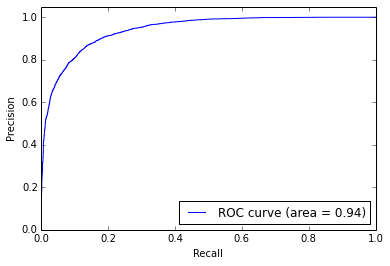

In [38]:
# Plot Precision-Recall curve
plt.clf()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc )
plt.legend(loc="lower right")
plt.show()

OK, AUC is 94% for word vectors vs 90% for simple bag of words.  Not bad ... but let's take a look at few data examples to see what's going on under the hood.

In [59]:
diffs = np.where( clf.predict( testDataVecs ) != test[ 'sentiment' ] )[0]

# print 1st few differences
print( diffs[ 1:3 ] )

[14 19]


In [57]:
BeautifulSoup( test.iloc[ 14, 2 ] ).get_text()

u'"Okay, sorry, but I loved this movie. I just love the whole 80\'s genre of these kind of movies, because you don\'t see many like this one anymore! I want to ask all of you people who say this movie is just a rip-off, or a cheesy imitation, what is it imitating? I\'ve never seen another movie like this one, well, not horror anyway.Basically its about the popular group in school, who like to make everyones lives living hell, so they decided to pick on this nerdy boy named Marty. It turns fatal when he really gets hurt from one of their little pranks.So, its like 10 years later, and the group of friends who hurt Marty start getting High School reunion letters. But...they are the only ones receiving them! So they return back to the old school, and one by one get knocked off by.......Yeah you probably know what happens!The only part that disappointed me was the very end. It could have been left off, or thought out better.I think you should give it a try, and try not to be to critical!~*~

In [58]:
BeautifulSoup( test.iloc[ 19, 2 ] ).get_text()

u'"A charming boy and his mother move to a middle of nowhere town, cats and death soon follow them. That about sums it up.I\'ll admit that I am a little freaked out by cats after seeing this movie. But in all seriousness in spite of the numerous things that are wrong with this film, and believe me there is plenty of that to go around, it is overall a very enjoyable viewing experience.The characters are more like caricatures here with only their basis instincts to rely on. Fear, greed, pride lust or anger seems to be all that motivate these people. Although it can be argued that that seeming failing, in actuality, serves the telling of the story. The supernatural premise and the fact that it is a Stephen King screenplay(not that I have anything specific against Mr. King) are quite nicely supported by some interesting FX work, makeup and quite suitable music. The absolute gem of this film is without a doubt Alice Krige who plays Mary Brady, the otherworldly mother.King manages to take a 

Well, hard to say what is driving these errors.  My bet is on double negations again, which simple classification methods will definitely strugle with.  
For the next encounter with NLP we will bring heavy machinery: Recurrent Neural Networks and see how they would perform with this task.